# **Reto 2**

Departamento de Ingeniería Biomédica

Universidad de los Andes

**IBIO-2440:** Fundamentos del machine learning


**Nombres de los integrantes**


1.  Laura Julieth Carretero Serrano
2.  Juan David Rios Nisperuza

**Número del grupo**

*3*




## **Explicación del problema**

El reto consiste en crear un modelo de aprendizaje que permita predecir cómo se mueve el pie izquierdo de un ciclista durante el pedaleo, utilizando únicamente información del pie derecho. Esto se hace porque medir ambos pies con equipos tridimensionales es costoso, pero si se logra un modelo que prediga el comportamiento del pie izquierdo a partir del derecho, se podrí usar solo un sistema bidimensional y aun así obtener una visión completa del movimiento. Para lograr esto, se pide entrenar un modelo de regresión lineal que tome los datos anteriores del pie derecho como entrada y devuelva el valor actual del pie izquierdo.

## **Definición de todos los componentes del problema de Regresión, donde se justifique su planteamiento y las unidades de trabajo.**

$$
\begin{aligned}
&\text{Sea }N\text{ el número total de muestras y }n\text{ el tamaño de la ventana (número de retardos).}\\
&\text{Definimos las señales en grados:}\\
&\quad R(k)\in\mathbb{R},\quad k=0,1,\dots,N-1,\quad\text{(ángulo del pie derecho)}\\
&\quad L(k)\in\mathbb{R},\quad k=0,1,\dots,N-1,\quad\text{(ángulo del pie izquierdo)}\\[0.5em]
&\text{Sea }m = N - n\quad\text{(número de muestras “útiles” tras aplicar retardos).}\\[0.5em]
&\text{Matriz de diseño }X\in\mathbb{R}^{m \times (n+1)}\text{ con componentes}\\
&\quad X_{k,i} \;=\; R\bigl(k + n - i\bigr),\quad
k=0,\dots,m-1,\;\;i=0,1,\dots,n,\\
&\quad\text{(cada retardo en grados).}\\[0.5em]
&\text{Vector objetivo }y\in\mathbb{R}^m\text{ definido por}\\
&\quad y_k = L\bigl(k + n\bigr),\quad k=0,\dots,m-1\quad\text{(grados).}\\[1em]
&\text{Modelo lineal con coeficientes }\beta\in\mathbb{R}^{(n+1)}:\\
&\quad \hat{y} \;=\; X\,\beta.\\[1em]
&\text{Debido a que las columnas de }X\text{ (retardos sucesivos) pueden estar altamente correlacionadas,}\\
&\quad \text{utilizamos regularización Ridge para mitigar la multicolinealidad y estabilizar la estimación de }\beta.\\[1em]
&\text{Para Ridge, minimizamos la función de costo:}\\
&\quad J(\beta) \;=\; \bigl\lVert X\beta - y\bigr\rVert_2^2 
\;+\; c\,\lVert \beta\rVert_2^2,\\
&\quad c\ge0\text{ es el coeficiente de regularización (adimensional).}\\[1em]
&\text{La solución analítica (ecuación normal regularizada) es:}\\
&\quad \beta \;=\; \bigl(X^\top X + c\,I_{n+1}\bigr)^{-1}\,X^\top y.\\[1em]
&\text{Para predecir con nueva serie }R_{\rm inc}(k),\;k=0,\dots,P-1,\\
&\quad X_{\rm inc}\in\mathbb{R}^{(P-n)\times(n+1)},\quad
(X_{\rm inc})_{k,i} = R_{\rm inc}\bigl(k + n - i\bigr),\\
&\quad\text{y las predicciones son } \hat L_{\rm inc} = X_{\rm inc}\,\beta\quad\text{(grados).}
\end{aligned}
$$


## **Descripción de la implementación del código utilizado**

1. **Funciones de preparación de datos**

   * **`crear_matriz_caracteristicas_y_objetivo`**: toma las series de ángulos del pie derecho (`valores_R`) y del pie izquierdo (`valores_L`) más el tamaño de ventana `n_ventana`. Primero añade un “padding” al inicio (repetición de los últimos valores) para poder formar retardos desde el instante $k=0$. Luego recorre esa serie ampliada, y en cada paso arma un vector de características de longitud $n+1$ con los valores retardados $[R(k),R(k-1),\dots,R(k-n)]$ y el valor objetivo correspondiente $L(k)$. Así devuelve la matriz $X$ y el vector $y$.
   * **`crear_matriz_caracteristicas_prediccion`**: Es similar a la función anterior, pero se utiliza para la prediccion de una serie del pie derecho (`valores_R`). Sirve para generar la matriz $X_{\mathrm{incógnita}}$ una vez elegidos los hiperparámetros.

2. **Función de entrenamiento**

   * **`entrenar_regresion_ridge`**: implementa la solución analítica de la regresión ridge. Crea la matriz identidad $I$ de tamaño $(n+1)\times(n+1)$, forma el término $X^\top X + c I$ y la parte derecha $X^\top y$, y resuelve el sistema lineal con `numpy.linalg.solve` para obtener directamente los coeficientes $\beta$.

3. **Búsqueda de hiperparámetros**

   * Se definen dos rangos:

     * ventanas `n` entre un z arbitario y p arbitrario (saltando los valores que dejen muy pocas muestras en entrenamiento).
     * parámetros de regularización `c` en 10 valores desde 0 hasta 1.
   * Para cada par $(n,c)$ se:

     1. Divide los datos en 80% entrenamiento y 20% validación.
     2. Construye $X_{\mathrm{ent}},y_{\mathrm{ent}}$ y $X_{\mathrm{val}},y_{\mathrm{val}}$.
     3. Entrena el modelo ridge y calcula el RMSE sobre validación.
     4. Si mejora el mejor RMSE, guarda $n$, $c$ y ese error.
   * Gracias a este bucle podemos comparar y elegir la ventana y el c que mejor predigan el pie izquierdo.

4. **Entrenamiento final y predicción**

   * Una vez hallados `mejor_n` y `mejor_c`, se reentrena el modelo usando TODO el conjunto original de pies derecho e izquierdo. Así obtenemos los coeficientes definitivos $\beta_{\mathrm{finales}}$.
   * Luego, con `crear_matriz_caracteristicas_prediccion`, se arma la matriz de incógnita a partir de los datos del pie derecho sin etiqueta, y se obtienen las predicciones $L_{\mathrm{pred}}$ aplicando la multiplicación $X_{\mathrm{incógnita}}\beta_{\mathrm{finales}}$.

5. **Generación y verificación de la salida**

   * Se crea un DataFrame con dos columnas:

     * `data`: los valores del pie derecho usados como entrada.
     * `prediction`: las predicciones del pie izquierdo.
   * Se guarda en `predictions.csv` (debe tener exactamente 2160 filas).
   * Finalmente se llama a `check_requirements()` del módulo `helpers` para asegurarse de que el formato del CSV cumple con lo solicitado

![Imagen de WhatsApp 2025-05-11 a las 14.54.07_275e1a53.jpg](<attachment:Imagen de WhatsApp 2025-05-11 a las 14.54.07_275e1a53.jpg>)
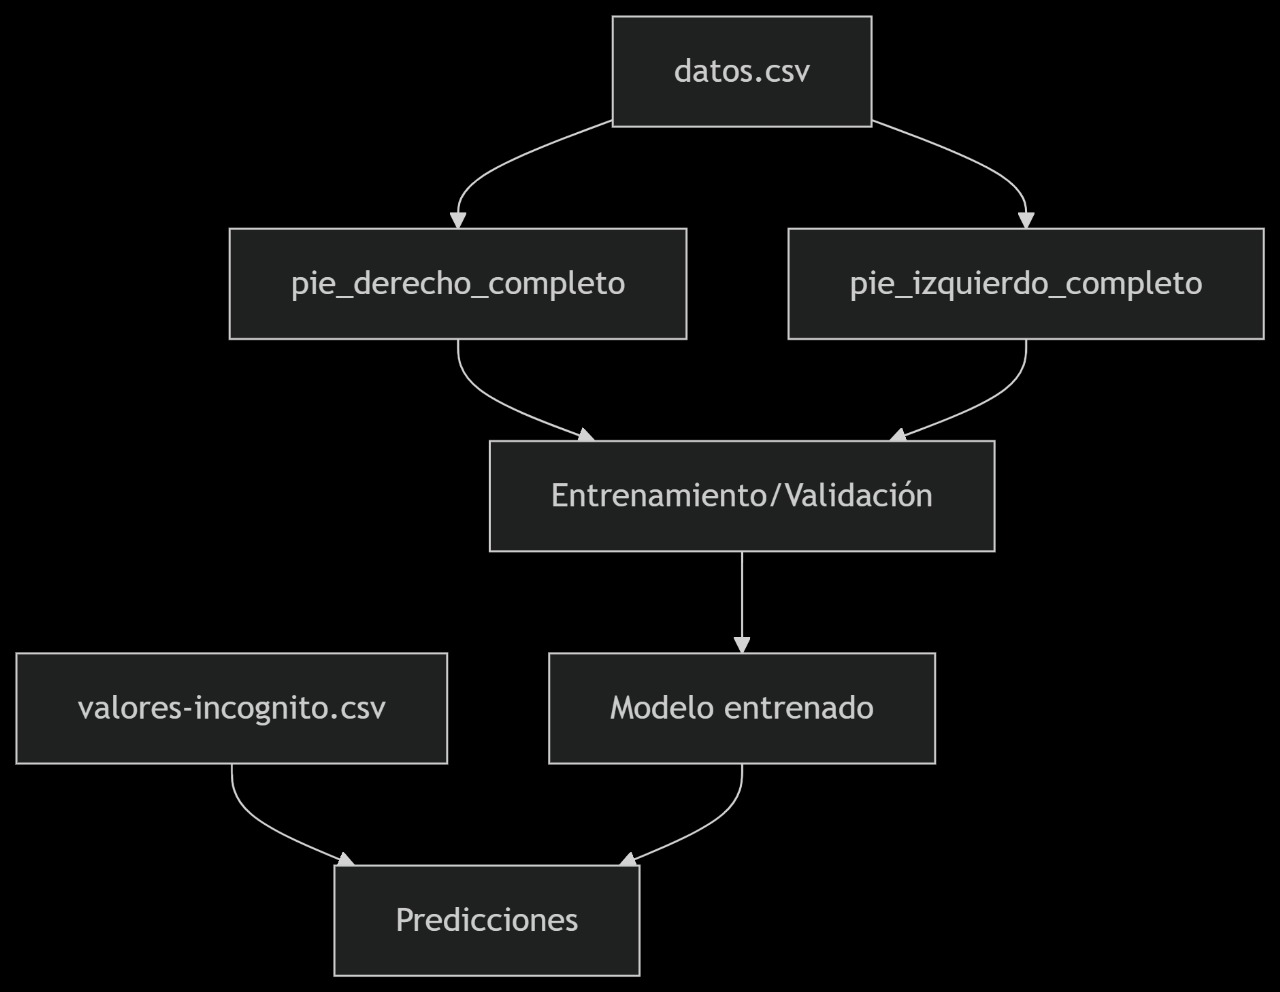

In [332]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [ ]:
def crear_matriz_caracteristicas_y_objetivo(valores_R, valores_L, n_ventana):
    """Crea la matriz de características X e el vector objetivo y para entrenamiento.
    valores_R: array de ángulos del pie derecho.
    valores_L: array de ángulos del pie izquierdo (objetivo).
    n_ventana: número de valores previos a usar en la ventana.
    Devuelve:
      X: arreglo de forma (muestras, n_ventana+1) con ventanas invertidas.
      y: arreglo de forma (muestras,) con valores objetivo.
    """
    # Determinar padding: si hay suficientes datos, usar los últimos n_ventana
    if len(valores_R) >= n_ventana:
        padding = valores_R[-n_ventana:]  # últimos n_ventana valores
    else:
        # Si no hay suficientes, repetir el último valor para completar
        padding = np.full(n_ventana, valores_R[-1])
    # Concatenar padding al inicio de la serie original
    valores_R_padded = np.concatenate([padding, valores_R])

    lista_X = []  # lista para almacenar vectores de características
    lista_y = []  # lista para almacenar valores objetivo

    # Recorremos desde k = n_ventana hasta el final del array padded
    for k in range(n_ventana, len(valores_R_padded)):
        # Tomar ventana de tamaño n_ventana+1 y voltear el orden
        ventana = valores_R_padded[k - n_ventana : k + 1]
        vector_caracteristicas = ventana[::-1]
        lista_X.append(vector_caracteristicas)
        # Solo si tenemos valores_L, agregamos objetivo
        if valores_L is not None:
            # El objetivo correspondiente se alinea con el inicio de la ventana
            lista_y.append(valores_L[k - n_ventana])

    # Convertir listas a numpy arrays y regresar
    return np.array(lista_X), np.array(lista_y)


def crear_matriz_caracteristicas_prediccion(valores_R, n_ventana):
    """Crea la matriz de características X para predicción futura.
    valores_R: array de ángulos del pie derecho hasta el instante actual.
    n_ventana: número de valores previos a usar.
    Devuelve:
      X_pred: arreglo de forma (muestras, n_ventana+1) listo para predecir.
    """
    # Padding con ceros para las primeras n_ventana entradas
    valores_R_padded = np.concatenate([np.zeros(n_ventana), valores_R])
    lista_X = []

    # Construir ventanas de igual forma que en entrenamiento
    for k in range(n_ventana, len(valores_R_padded)):
        ventana = valores_R_padded[k - n_ventana : k + 1]
        vector_caracteristicas = ventana[::-1]
        lista_X.append(vector_caracteristicas)
        
    return np.array(lista_X)


def entrenar_regresion_ridge(X_entrenamiento, y_entrenamiento, c_regularizacion):
    """Calcula los coeficientes beta de Ridge Regression.
    X_entrenamiento: matriz de características (muestras, características).
    y_entrenamiento: vector objetivo (muestras,).
    c_regularizacion: parámetro lambda para regularización.
    Devuelve:
      beta: vector de coeficientes de forma (características,).
    """
    num_caracteristicas = X_entrenamiento.shape[1]
    # Matriz identidad para terminos de regularización
    I = np.identity(num_caracteristicas)
    # Construir matriz (X^T X + lambda I)
    A = X_entrenamiento.T @ X_entrenamiento + c_regularizacion * I
    # Vector X^T y
    b = X_entrenamiento.T @ y_entrenamiento
    # Resolver sistema lineal para obtener beta
    beta = np.linalg.solve(A, b)
    return beta


In [ ]:
# --- Carga de datos y parámetros ---
df_datos = pd.read_csv("datos.csv")
df_incognita =  pd.read_csv("valores-incognito .csv")

# Extraer datos de los pies
pie_derecho = df_datos["Right foot rotation"].values
pie_izquierdo = df_datos["Left foot rotation"].values

# Extraer datos de la incógnita
valores_incognita = df_incognita["data"].values

# Ajustar rango de 'n' dinámicamente
rango_n_hiper = [299,365,200,1000,1750]
rango_c_hiper = [1,2]
resultados = []

# --- Búsqueda de hiperparámetros ---
mejor_n, mejor_c, mejor_rmse = -1, -1.0, float('inf')
for n in tqdm(rango_n_hiper):
    if n >= len(pie_derecho) // 2:
        continue
    X_ent, y_ent = crear_matriz_caracteristicas_y_objetivo(pie_derecho[:int(0.8*len(pie_derecho))], 
                                                          pie_izquierdo[:int(0.8*len(pie_izquierdo))], n)
    X_val, y_val = crear_matriz_caracteristicas_y_objetivo(pie_derecho[int(0.8*len(pie_derecho)):], 
                                                          pie_izquierdo[int(0.8*len(pie_izquierdo)):], n)
    if X_ent.shape[0] == 0 or X_val.shape[0] == 0:
        continue
    for c in rango_c_hiper:
        beta = entrenar_regresion_ridge(X_ent, y_ent, c)
        y_pred = X_val @ beta
        rmse = np.sqrt(np.mean((y_val - y_pred)**2))
        resultados.append({
            "Valor ventana (N)": n,
            "Lambda (C)": c,
            "RMSE Calculado": rmse
        })
        if rmse < mejor_rmse:
            mejor_n, mejor_c, mejor_rmse = n, c, rmse


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


In [335]:
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by="RMSE Calculado").reset_index(drop=True)
df_resultados.head(20)

,Valor ventana (N),Lambda (C),RMSE Calculado
0,365,1,0.607030
1,365,2,0.607063
2,299,1,0.608408
3,299,2,0.608497
4,200,1,0.622926
5,200,2,0.623018
6,1750,2,0.631871
7,1750,1,0.631882
8,1000,2,0.637864
9,1000,1,0.637920


## **Selección del mejor hiperparámetro**
De la búsqueda presentamos que el mejor modelo corresponde a una ventana de historial de 365 muestras (n = 365) y una regularización de λ = 1. Este modelo alcanzó un RMSE de aproximadamente 0.607 sobre el conjunto de validación.

In [336]:
print("Mejor n:", mejor_n)
print("Mejor c:", mejor_c)

Mejor n: 365
Mejor c: 1


In [337]:
# --- Entrenamiento final y predicción ---
X_final, y_final = crear_matriz_caracteristicas_y_objetivo(pie_derecho, pie_izquierdo, mejor_n)
coeficientes_beta_finales = entrenar_regresion_ridge(X_final, y_final, mejor_c)

# --- Preparar datos incógnita con padding ---
X_incognita = crear_matriz_caracteristicas_prediccion(valores_incognita, mejor_n)
L_predichos_incognita = X_incognita @ coeficientes_beta_finales


In [ ]:
# --- Guardar resultados en formato requerido ---
df_salida = pd.DataFrame({
    'data': valores_incognita,
    'prediction': L_predichos_incognita
})
df_salida.to_csv("predictions.csv", index=False)

print("Predicciones guardadas en 'predictions.csv'")

# --- Verificación final ---
from helpers import check_requirements
check_requirements()

Predicciones guardadas en 'predictions.csv'
Archivos encontrados: ['datos.csv', 'predictions.csv', 'solucion.csv', 'solucion_reto_regresion.csv', 'valores-incognito .csv']
Archivo cargado correctamente
Columnas encontradas
Columna prediction encontrada
Las columnas tienen el nombre correcto
El archivo predictions.csv no está vacío
La cantidad de predicciones es correcta
Requisitos completados


# **Análisis del modelo final desde el contexto del problema**

En este reto se buscó reemplazar la medición tridimensional —costosa por el uso de cámaras infrarrojas y software especializado— por un método bidimensional, basado únicamente en la serie temporal de ángulos del pie derecho para predecir el comportamiento del pie izquierdo .

El modelo seleccionado emplea una ventana de historia de **365 ángulos previos** (*n* = 365) y un coeficiente de regularización **λ = 1**, alcanzando un RMSE de aproximadamente **0,6°** en validación. En la práctica, esto significa:

* **Captura integral del movimiento**: Al usar 365 ángulos anteriores, la ventana puede abarcar todo el ciclo de pedaleo, incluyendo tanto el empuje como la recuperación.
* **Precisión suficiente**: Un error medio de 0,6° es inferior al **3 %** de la amplitud típica de dicho movimiento, lo que permite detectar sutiles asimetrías sin equipamiento 3D.
Para un laboratorio de Análisis de Movimiento, estos resultados muestran que basta con la cinemática de un solo pie (derecho) para estimar con precisión el movimiento del pie contrario, lo cual permite:

Para un laboratorio de Análisis de Movimiento, estos resultados muestran que basta con la cinemática de un solo pie (derecho) para estimar con precisión el movimiento del pie contrario, lo cual permite:

1. **Reducción de costos**: Se elimina la necesidad de marcadores y cámaras infrarrojas, manteniendo la calidad de la predicción con hardware básico (video 2D o sensores inerciales simples).
2. **Aplicabilidad en terreno**: Ciclistas pueden autoevaluarse en ruta, usando un smartphone o cámara convencional, sin acceso a un laboratorio especializado.

